## Ethereum Account Explorer

A Sandbox to tinker with the [etherscan API](https://docs.etherscan.io/) and collect basic information of certain ETH addresses

In [74]:
# Create a simple dashboard to explore ETH accounts and draw interesting insights from it

import requests
import json
import pandas as pd

api_key = 'XKRX3IKUZHUXDWWQ3QXRPDSDSJB4PIR59I' # disposable api_key
url = 'https://api.etherscan.io/'

In [75]:
# Find balance from a wallet address

address = '0x636C933984F1Ce096b7E0b0Cd258CbE34668259f' # my address 🤫

response = requests.get(f'https://api.etherscan.io/api?module=account&action=balance&address={address}&tag=latest&apikey={api_key}')
data = response.json()

# sample result: {'status': '1', 'message': 'OK', 'result': '113437741326753000'}
# change unit to ETH

print(f"{int(data['result']) / 10**18} ETH")

0.113437741326753 ETH


### codehash

In Ethereum, the codehash refers to the hash value of the bytecode that comprises a smart contract. Every Ethereum account can have code associated with it, and this code is executed on the Ethereum Virtual Machine (EVM) when a transaction is sent to the account. The codehash is used as an identifier of the code that is currently associated with the account. If the code for an account changes, the codehash will also change. This makes it possible for other contracts or users to check if a particular account has the expected code by comparing the codehash value with an expected value.

### storageroot

In Ethereum, a smart contract's state is stored in its storage, which is essentially a key-value store. Each key-value pair in storage is stored in a particular location in the Merkle Tree, and the root hash of this tree is called the storage root. The storage root acts as a unique identifier for the current state of the contract. Whenever a change is made to the state of the contract, such as updating a value in storage, the storage root changes accordingly.

#### **TLDR: both helps user/contract owner to verify that the contract's storage has not been tampered with.**

In [76]:
# Get codehash and storageroot of an address

chainlink_token_address = '0x514910771AF9Ca656af840dff83E8264EcF986CA'

def truncate_string(string, length):
    if len(string) > length:
        return string[:length-3] + "..."
    else:
        return string
    
response = requests.get(f'https://api.etherscan.io/api?module=proxy&action=eth_getCode&address={chainlink_token_address}&tag=latest&apikey={api_key}')
data = response.json()
print(f"codehash = {truncate_string(data['result'], 20)}")

# etherscan API on storageroot is still buggy
response = requests.get(f'https://api.etherscan.io/api?module=proxy&action=eth_getStorageAt&address={chainlink_token_address}&position=0x0&tag=latest&apikey={api_key}')
data = response.json()
print(f"storageroot = {data['result']}")



codehash = 0x606060405236156...
storageroot = 0x0000000000000000000000000000000000000000000000000000000000000000


## Testing time-series data

Here I'm testing to see how many transactions per block have been validated in the past 25 blocks. This can be useful to monitor the overall traffic of the Ethereum network. Sudden spike of transactions may indicate a significant increase in demand for validation, leading to slower tx time and higher fees.

In [38]:
# Display latest 5 transactions

no_transactions = 5

response = requests.get(f'https://api.etherscan.io/api?module=account&action=txlist&address={address}&startblock=0&endblock=99999999&page=1&offset=10&sort=asc&apikey={api_key}')
data = response.json()
df = pd.json_normalize(data['result'])

print(df[['blockNumber', 'timeStamp', 'from', 'to', 'value', 'gas']].head(no_transactions))

  blockNumber   timeStamp                                        from   
0    13666831  1637615677  0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511  \
1    15466169  1662219090  0x636c933984f1ce096b7e0b0cd258cbe34668259f   

                                           to               value    gas  
0  0x636c933984f1ce096b7e0b0cd258cbe34668259f  123579610000000000  21000  
1  0x1e310ffd91293aff99fb3312cf75098e20d02df0   10000000000000000  21000  


In [61]:
# Get list of blockNumbers from time period

blocks_behind = 25

latest_block = int(requests.get(f'https://api.etherscan.io/api?module=proxy&action=eth_blockNumber&apikey={api_key}').json()['result'], 16)
start_block = latest_block - blocks_behind

blockNums = list(range(start_block, latest_block))
transactionsCount = []

for blockNum in range(start_block, latest_block):
    response = requests.get(f'https://api.etherscan.io/api?module=proxy&action=eth_getBlockByNumber&tag={hex(blockNum)}&boolean=true&apikey={api_key}')
    data = response.json()
    transactionsCount.append(len(data['result']['transactions']))

# for blockNum in range(start_block, test_block):
#     response = requests.get(f'https://api.etherscan.io/api?module=proxy&action=eth_getBlockByNumber&tag={hex(blockNum)}&boolean=true&apikey={api_key}')
#     data = response.json()
#     transactionsCount.append(len(data['result']['transactions']))

print(transactionsCount)

[306, 119, 201, 165, 114, 145, 233, 167, 203, 212, 159, 153, 151, 146, 219, 257, 126, 208, 283, 221, 126, 221, 122, 226, 128]


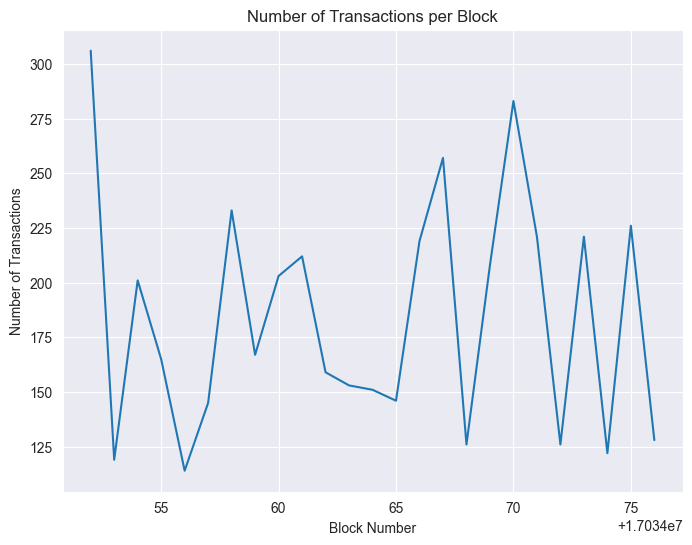

In [63]:
# visualize the chart

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')  # Set seaborn style
plt.figure(figsize=(8, 6))  # Set figure size

sns.lineplot(x=blockNums, y=transactionsCount)
plt.title('Number of Transactions per Block')  # Set the title
plt.xlabel('Block Number')  # Set the x-axis label
plt.ylabel('Number of Transactions')  # Set the y-axis label

plt.show()  # Show the plot